**Created by Muhammed El-Yamani**

**🚀 Clothing type classifier Techsquadeg**

**15 Jun 2022**


# Problem Statment

Assume that we would like to create **a clothing type classifier**. 

You are required to select one of the **freely available datasets** and **create an initial model** to deliver a prototype of the solution. 

It’s recommended to use google colab for this task since it’s free and easily shareable. 

**Deliverables:**


1. A Github repository containing your solution

2. A ReadMe detailing the steps you took to solve the problem, your approach, your data handling techniques, any problems you faced, and the results of your tests.

3. A summary of the results and metrics you choose to evaluate

4. A presentation to illustrate your results (will be discussed during the evaluation process)


-----------------------------------------------------
 



**Notes:**


1.   Use proper data handling and data loading: Done 

2.   Explore multiple solutions and showcase why you chose the final one
Be clear on your choice of metrics and why you chose them.

3. Make sure to write clean, modular, and well-documented code.: Done 

4. Make sure to keep your approach optimum as much as possible for deployment, with minimal model size and the number of FLOPS.


You are not expected to reach optimal results, but it is very critical for you to showcase how you approach the problem and outline your thought process.


Best of luck


In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/MyDrive/jobs_assignments/techsquadeg

## Import libraries

In [2]:
import logging
logging.basicConfig( level=logging.INFO, format="%(message)s")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
import glob
import matplotlib.pyplot as plt
from torchvision import  models
import logging
import matplotlib as mpl
# define Train function

mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12) 
%matplotlib inline


mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

In [3]:
# from nn import NET
# NET(3,46, [], 0.2)

In [4]:
# helper files
from yamani.utils.scores import calc_accuracy
from yamani.utils import utils, generate_images
from yamani.utils.load_dataset import get_dataset_dataloader
from yamani.evaluate import evaluate, get_predictions
from yamani.net_utils import Net_Utility, load_checkpoint
from yamani.nn import NET, Network

NumExpr defaulting to 8 threads.


## Global variables

In [5]:
LOCAL_DATASET_PATH='dataset'
LOCAL_RAW_DATASET_PATH = 'source_dataset'
CHECKPOINT_PATH='checkpoint'
GENERATE_IMAGES=False

In [6]:
DEBUG=False
TRAIN_KEEP_DATA_FACTOR=0.1
VAL_KEEP_DATA_FACTOR=0.1
TEST_KEEP_DATA_FACTOR=0.1
# TYPE_LOAD_MODEL: load_best | load_interrupted | load_last | create_new
TYPE_LOAD_MODEL='load_best'
PRINT_EVERY=None
DELAY_EPOCHS_EARLY_STOPPING=2
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
BATCH_SIZE = 32
N_CLASSES = 46
SEED=0
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
# MULTIPLE_TRAIN_SIZE = 2
LOADER_ARGS = dict(batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 5
LEARNING_RATE = 1e-3
PATIENCE_SCHEDULER = 2 # update lr each num steps (batches in the epoch) 
FACTOR_SCHEDULER = 0.1
IS_TRAIN = True
print(f'Using device {DEVICE}')

Using device cuda


In [7]:
if DEBUG:
    print("Debug mode")
    TRAIN_KEEP_DATA_FACTOR = 0.001
    VAL_KEEP_DATA_FACTOR = 0.001
    TEST_KEEP_DATA_FACTOR = 0.001
    EPOCHS = 1
    PRINT_EVERY = 1


## Preparing Datasets

- source_dataset/Anno_coarse/
  - list_category_cloth.txt
  - list_category_img.txt

- source_dataset/Eval
  - list_eval_partition.txt

- source_dataset/Img
  - img.zip

### <span style="color:#e76f51;">Citation Dataset</span>


@inproceedings{liuLQWTcvpr16DeepFashion,<br>

 author = {Liu, Ziwei and Luo, Ping and Qiu, Shi and Wang, Xiaogang and Tang, Xiaoou},<br>

 title = {DeepFashion: Powering Robust Clothes Recognition and Retrieval with Rich Annotations},<br>

 booktitle = {Proceedings of IEEE Conference on Computer Vision and Pattern Recognition (CVPR)},<br>

 month = {June},<br>

 year = {2016}<br>

 }<br>
 

<a href="https://drive.google.com/drive/u/0/folders/0B7EVK8r0v71pWGplNFhjc01NbzQ?resourcekey=0-BU3lAk-Nc7HscJu-CyC1yA">Source Dataset</a>

In [8]:
generate_images.prepare_images(LOCAL_RAW_DATASET_PATH, LOCAL_DATASET_PATH, GENERATE_IMAGES)

Notes README.md from source_dataset:
1. The long side of images are resized to 300;
2. The aspect ratios of original images are kept unchanged.

## Data loaders 

- transforms
- augmentation

In [9]:
data_loaders= dict()
image_datasets= dict()
data_transforms= dict()
train_dataset, train_dataloader=get_dataset_dataloader(dataset_path= LOCAL_DATASET_PATH, image_size= IMAGE_SIZE, split='train', aug_train=True, keep_data_factor= TRAIN_KEEP_DATA_FACTOR, seed = SEED, shuffle=True, loader_args=LOADER_ARGS)
val_dataset, val_dataloader=get_dataset_dataloader(dataset_path= LOCAL_DATASET_PATH, image_size= IMAGE_SIZE, split='val', aug_train=True, keep_data_factor= VAL_KEEP_DATA_FACTOR, seed = SEED, shuffle=True, loader_args=LOADER_ARGS)
test_dataset, test_dataloader=get_dataset_dataloader(dataset_path= LOCAL_DATASET_PATH, image_size= IMAGE_SIZE, split='test', aug_train=True, keep_data_factor= TEST_KEEP_DATA_FACTOR, seed = SEED, shuffle=True, loader_args=LOADER_ARGS)

train dataset: 20922 images
val dataset: 4000 images
test dataset: 4000 images


In [10]:
image_datasets={'train': train_dataset, 'val': val_dataset, 'test': test_dataset}
data_loaders={'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}

In [11]:
classes_names = image_datasets['train'].class_names
print("number of classes in train datasets: ", len(classes_names))

number of classes in train datasets:  46


In [12]:
print("number of classes in val datasets: ", len(image_datasets['val'].class_names))

number of classes in val datasets:  46


In [13]:
print("number of classes in tes datasets: ", len(image_datasets['test'].class_names))

number of classes in tes datasets:  46


In [14]:
if not DEBUG:
    print("Check the order of indices for the datasets")
    
    n1 = np.sum(image_datasets['train'].class_names ==
                image_datasets['val'].class_names)
    n2 = np.sum(image_datasets['train'].class_names ==
                image_datasets['test'].class_names)
    if n1 + n2 == 2*N_CLASSES:
        print("Every thing is ok")
    else:
        raise
    

Check the order of indices for the datasets
Every thing is ok


## Explore The Dataset

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Explore The Datase:</u></b><br>
 
* <i>RGB images</i><br>
* <i>train dataset: 209222 images</i><br>
* <i>val dataset: 40000 images</i><br>
* <i>test dataset: 40000 images </i><br>
* <i>Classes: 46 </i><br>
* <i>The classes not balanced with skewed graph </i><br>
* <i>The class **Dress** has the greatest size with **52138**  </i><br>
* <i>The class **Halter** has the lowest size with **11**  </i><br>
* <i>The image has more than label but annotated with only label. So there is noise in the images. </i><br>

----------------------------------------------------------------

**Solution for imbalanced**

We can solve this problem by making augmentation to generate more datasets for the classes with the weights of their distribution.


We have 52138 images for Dress. So the new data will be 52138*46 ~ 2.4e6. 

**The advantages:**

- The model will not be biased towards some classes and perhaps we get better results.

From 2.1e4   to   2.4e6.

I will let this approach for future works.

----------------------------------------------------------------

**The original dataset takes great time to train**

The original data has a large dataset and takes a very long time to evaluate, almost 2 hours per validation set. 

So I decided to work only on 10% of the original data to speed up my work.

And this approach has another advantage which tries to solve the imbalanced data, as we see in the distributions below. 

----------------------------------------------------------------

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>After preprocessing & Augmentation & taking the most important data:</u></b><br>
 
* <i>Normalaized RGB images</i><br>
* <i>train dataset: 20922 images</i><br>
* <i>val dataset: 4000 images</i><br>
* <i>test dataset: 4000 images </i><br>
* <i>Classes: 46 </i><br>
* <i>The classes almost balanced better than original </i><br>
* <i>The class **Dress** has the greatest size with **723**  </i><br>
* <i>The class **Halter** has the lowest size with **11**  </i><br>
* <i>Images 3 channels RGB float range(-2.1179, 2.6400) </i><br>
* <i>Labels int range(0, 45) </i><br>
* <i>Class names images  </i><br>



<table>
  <tr>
    <td>Anorak</td>
    <td>Blazer</td>
    <td>Blouse</td>
    <td>Bomber</td>
    <td>Trunks</td>
  </tr>
    <tr>
    <td>Button-Down</td>
    <td>Caftan</td>
    <td>Capris</td>
    <td>Cardigan</td>
    <td>Chinos</td>
  </tr>
    <tr>
    <td>Coat</td>
    <td>Coverup</td>
    <td>Culottes</td>
    <td>Cutoffs</td>
    <td>Dress</td>
  </tr>
  <tr>
    <td>Flannel</td>
    <td>Gauchos</td>
    <td>Halter</td>
    <td>Henley</td>
    <td>Hoodie</td>
  </tr>
    <tr>
    <td>Jacket</td>
    <td>Jeans</td>
    <td>Jeggings</td>
    <td>Jersey</td>
    <td>Jodhpurs</td>
  </tr>
    <tr>
    <td>Joggers</td>
    <td>Jumpsuit</td>
    <td>Kaftan</td>
    <td>Kimono</td>
    <td>Leggings</td>
  </tr>
    <tr>
    <td>Onesie</td>
    <td>Parka</td>
    <td>Peacoat</td>
    <td>Poncho</td>
    <td>Robe</td>
  </tr>
    <tr>
    <td>Romper</td>
    <td>Sarong</td>
    <td>Shorts</td>
    <td>Skirt</td>
    <td>Sweater</td>
  </tr>
    <tr>
    <td>Sweatpants</td>
    <td>Sweatshorts</td>
    <td>Tank</td>
    <td>Tee</td>
    <td>Top</td>
    <td>Turtleneck</td>
  </tr>
</table>



In [15]:
# image_datasets['train'].plot_distribution()

In [16]:
# image_datasets['val'].plot_distribution()

In [17]:
# image_datasets['test'].plot_distribution()

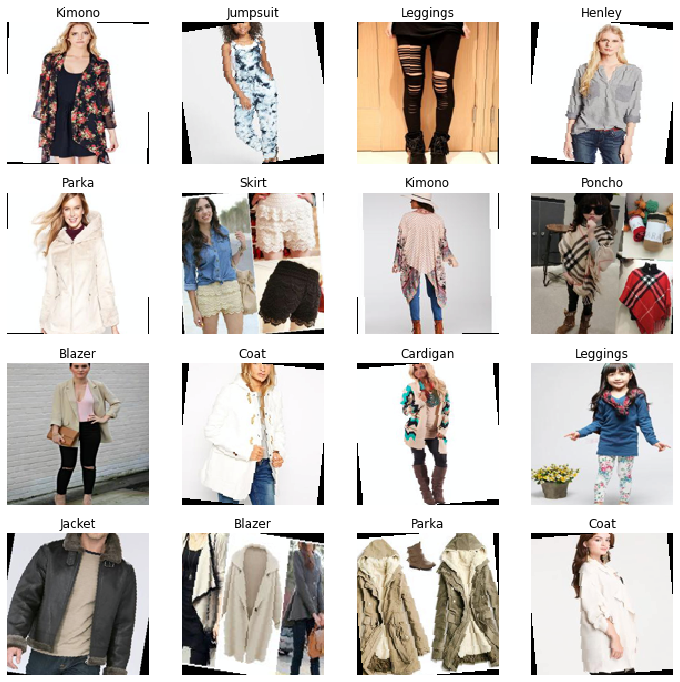

In [18]:
train_data_iter = iter(data_loaders['train'])
batch = train_data_iter.next()
images, labels = batch
plt.figure(figsize=(12, 12))
for index in range(0, min(16, len(images))):
    ax = plt.subplot(4, 4, index + 1)
    utils.imshow(images[index], ax=ax, title =classes_names[labels[index]] , normalize=True)



In [19]:
print(images.min())
print(images.max())
print(labels.min())
print(labels.max())
print(images.shape)


tensor(-2.1179)
tensor(2.6400)
tensor(1)
tensor(43)
torch.Size([32, 3, 128, 128])


**Analasis the problem**

Three fundamental challenges:

- Clothes often have large variations in style, texture, and cutting.

- Clothing items are frequently subject to deformation and occlusion. 

- Clothing images often exhibit serious variations when they are taken
under different scenarios, such as selfies vs. online shopping
photos.

<a href="https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Liu_DeepFashion_Powering_Robust_CVPR_2016_paper.pdf">1. Introduction</a>


## Training

### <span style="color:#e76f51;">References</span>

- <a href="https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Liu_DeepFashion_Powering_Robust_CVPR_2016_paper.pdf">DeepFashion: Powering Robust Clothes Recognition and Retrieval with Rich Annotations, CVPR 2016</a>


- Compare to benchmark
- Transfere learning on vgg16...
- Build smaller custom cnn

In [20]:
mpl.rcParams['figure.figsize'] = 15, 15

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>EXperiment1: Transfer learning using vgg16:</u></b><br>


 
- hidden layers = [64]

- lr = 0.001

- dropout = 0.2

- The descriptor has size <b>25088 1-dim vector</b> from any size from the image

- Epoch 4 .. train_loss: 2.270.. valid_loss: 2.313 .. valid_accuracy: 33.225%


<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>EXperiment2: Transfer learning using vgg16:</u></b><br>


- hidden layers = [1024, 128]

- lr = 0.001 

- dropout = 0.2

- The descriptor has size <b>25088 1-dim vector</b> from any size from the image

- Epoch 5 train_loss: 2.009.. valid_loss: 2.193 .. valid_accuracy: 38.325

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>EXperiment3: Increase train data size: VGG16</u></b><br>

- Epoch 1 .. train_loss: 1.616.. valid_loss: 2.815 .. valid_accuracy: 28.025%

- lr = 0.001  - whole data - Training size: 209222  -  headen sizes:   [1024, 128]

Note we should train on small data because epoch takes ~ 3 hours. Then after some good results we can fune the model with the whole original data.


In [21]:
# Choose the pretrained model
# model = models.vgg16(pretrained=True)
# model.classifier

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>EXperiment4: Transfer learning using resnet34:</u></b><br>


 
- The descriptor has size <b>512 1-dim vector</b> from any size from the image

- No hidden layers

- lr = 0.001

- Epoch: 4 .. train_loss: 2.195, valid_loss: 2.288, valid_accuracy: 35.475

- test_loss: 2.313, test_accuracy: 33.325%


<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>EXperiment5: Transfer learning using resnet34:</u></b><br>


 
- The descriptor has size <b>512 1-dim vector</b> from any size from the image

- Apply schedular for lr, and starting lr with 0.1

- Epoch 2 .. train_loss: 6.277.. valid_loss: 6.521 .. valid_accuracy: 30.150%

-----------------------------------------------------------

- Apply schedular for lr, and starting lr with 0.01


- Epoch: 2 .. train_loss: 2.198, valid_loss: 2.409, valid_accuracy: 35.050
    

In [22]:
# Choose the pretrained model
# model = models.resnet34(pretrained=True)
# model.fc

In [23]:
# Freeze the parameters
# for param in model.parameters():
#     param.requires_grad = False

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>EXperiment6: Custom CNN:</u></b><br>

### Analysis these parameters

In [24]:
# define netwrok
# try:
#     FEATURE_DESCRIPTOR_SIZE = model.classifier[0].in_features
# except:
#     FEATURE_DESCRIPTOR_SIZE = model.fc.in_features

# HEADEN_SIZES = [64]
# HEADEN_SIZES = [1024, 128]
HEADEN_SIZES = []
# DROPOUT = 0.2
DROPOUT = 0
# classifier = Network(input_size=FEATURE_DESCRIPTOR_SIZE, output_size=N_CLASSES,
#                      hidden_sizes=HEADEN_SIZES, dropout_p=DROPOUT)

# transfer learning
# model.classifier = classifier
# model.fc = classifier
# Configure optimizer
# try:
#     optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)
# except:
#     optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)
# RGB -> 3 channels
model = NET(input_channels=3, n_classes=N_CLASSES,
            hidden_sizes=HEADEN_SIZES, dropout_p=DROPOUT)
FEATURE_DESCRIPTOR_SIZE = model.fc[0].in_features
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# criterion
criterion = nn.NLLLoss()


In [25]:
try:
    classifier = model.classifier
except:
    classifier = model.fc
print(classifier)

ModuleList(
  (0): Linear(in_features=512, out_features=46, bias=True)
)


In [26]:
# Check if the last layer is ok 
try:
    classifier = model.classifier
except:
    classifier = model.fc
broken_param_n = np.sum([not par.requires_grad for par in classifier.parameters()])
if broken_param_n == 0:
    print('Every thing is ok')
else:
    print('make sure the parameters require grade')
    raise

Every thing is ok


In [27]:
# Save the checkpoint
checkpoint_dict = {}
checkpoint_dict['input_size'] = FEATURE_DESCRIPTOR_SIZE
checkpoint_dict['output_size'] = N_CLASSES
checkpoint_dict['hidden_sizes'] = HEADEN_SIZES
checkpoint_dict['dropout_p'] = DROPOUT
checkpoint_dict['optimzier_state_dict'] = optimizer.state_dict()
checkpoint_dict['class_names'] = image_datasets['train'].class_names
checkpoint_dict['arch'] = 'custom_cnn'
checkpoint_dict['criterion'] = criterion

In [28]:
cloth_utility_exp1 = Net_Utility(model, checkpoint_dict, optimizer, criterion, data_loaders,
                                 image_datasets, IMAGE_SIZE, delay=DELAY_EPOCHS_EARLY_STOPPING,
                                 n_classes=N_CLASSES, factor_scheduler=FACTOR_SCHEDULER, patience_scheduler=PATIENCE_SCHEDULER,
                                 save_checkpoint=True, is_train=IS_TRAIN, type_load_model=TYPE_LOAD_MODEL,
                                 epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE,
                                 print_every=PRINT_EVERY, debug=DEBUG)


Using device cuda
Train new model
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: muhammed-elyamani. Use `wandb login --relogin` to force relogin
2022-06-19 00:06:02.819439: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Starting training:
                Epochs:             5
                Batch size:         32
                Learning rate:      0.001
                Patience scheduler  2 
                Factor scheduler    0.1
                Training size:      20922
                valid size:         4000
                Checkpoints:        True
                Device:             cuda
                Images size:        (128, 128)
                Descriptor size:    512
                N classes:          46
                Headed sizes:       []
                Dropout:            0
                Arch:               custom_cnn
                Criterion:          NLLLoss()
            
Epoch 1/5:  10%|▉         | 2080/20922 [00:26<03:34, 87.75img/s, loss (batch)=3.23] 
1/5 .. train_loss: 3.629.. valid_loss: 3.679 .. valid_accuracy: 5.950%
Epoch 1/5:  20%|█▉        | 4160/20922 [00:54<02:27, 113.88img/s, loss (batch)=3.5] 
1/5 .. train_loss: 3.424.. valid_loss: 3.614 .. valid_accuracy: 7.00

Winning: better model


Epoch 2/5:   9%|▉         | 1952/20922 [00:04<00:43, 435.34img/s, loss (batch)=3.07]
2/5 .. train_loss: 2.589.. valid_loss: 3.423 .. valid_accuracy: 10.000%
Epoch 2/5:  19%|█▉        | 4032/20922 [00:17<00:39, 430.18img/s, loss (batch)=2.57]
2/5 .. train_loss: 2.746.. valid_loss: 3.436 .. valid_accuracy: 10.475%
Epoch 2/5:  29%|██▉       | 6112/20922 [00:31<00:41, 356.91img/s, loss (batch)=2.73]
2/5 .. train_loss: 2.754.. valid_loss: 3.404 .. valid_accuracy: 10.450%
Epoch 2/5:  39%|███▉      | 8192/20922 [00:45<00:31, 408.07img/s, loss (batch)=2.84]
2/5 .. train_loss: 2.678.. valid_loss: 3.403 .. valid_accuracy: 10.875%
Epoch 2/5:  49%|████▉     | 10272/20922 [01:02<00:24, 433.80img/s, loss (batch)=2.45]
2/5 .. train_loss: 2.756.. valid_loss: 3.394 .. valid_accuracy: 10.975%
Epoch 2/5:  59%|█████▉    | 12352/20922 [01:19<00:23, 371.57img/s, loss (batch)=3.18]
2/5 .. train_loss: 2.712.. valid_loss: 3.381 .. valid_accuracy: 10.800%
Epoch 2/5:  69%|██████▉   | 14432/20922 [01:37<00:47, 13

Winning: better model


Epoch 3/5:   9%|▊         | 1824/20922 [00:05<00:41, 458.77img/s, loss (batch)=2.74]
3/5 .. train_loss: 2.330.. valid_loss: 3.369 .. valid_accuracy: 11.275%
Epoch 3/5:  19%|█▊        | 3904/20922 [00:24<01:00, 280.59img/s, loss (batch)=2.42]
3/5 .. train_loss: 2.633.. valid_loss: 3.382 .. valid_accuracy: 11.125%
Epoch 3/5:  29%|██▊       | 5984/20922 [00:41<00:47, 313.11img/s, loss (batch)=3.07]
3/5 .. train_loss: 2.691.. valid_loss: 3.392 .. valid_accuracy: 11.075%
Epoch 3/5:  39%|███▊      | 8064/20922 [01:11<00:31, 412.56img/s, loss (batch)=2.6] 
3/5 .. train_loss: 2.664.. valid_loss: 3.364 .. valid_accuracy: 11.600%
Epoch 3/5:  48%|████▊     | 10144/20922 [01:19<00:29, 361.42img/s, loss (batch)=2.83]
3/5 .. train_loss: 2.616.. valid_loss: 3.380 .. valid_accuracy: 11.275%
Epoch 3/5:  58%|█████▊    | 12224/20922 [01:38<00:59, 146.45img/s, loss (batch)=2.47]
3/5 .. train_loss: 2.602.. valid_loss: 3.365 .. valid_accuracy: 11.475%
Epoch 3/5:  68%|██████▊   | 14304/20922 [01:56<00:17, 37

Winning: better model


Epoch 4/5:   8%|▊         | 1696/20922 [00:05<00:41, 458.49img/s, loss (batch)=2.73]
4/5 .. train_loss: 2.156.. valid_loss: 3.372 .. valid_accuracy: 11.300%
Epoch 4/5:  18%|█▊        | 3776/20922 [00:22<00:51, 336.01img/s, loss (batch)=3.14]
4/5 .. train_loss: 2.628.. valid_loss: 3.379 .. valid_accuracy: 11.050%
Epoch 4/5:  28%|██▊       | 5856/20922 [00:40<00:37, 406.46img/s, loss (batch)=2.44]
4/5 .. train_loss: 2.632.. valid_loss: 3.373 .. valid_accuracy: 11.300%
Epoch 4/5:  38%|███▊      | 7936/20922 [00:59<01:21, 160.31img/s, loss (batch)=2.84]
4/5 .. train_loss: 2.669.. valid_loss: 3.367 .. valid_accuracy: 11.275%
Epoch 4/5:  48%|████▊     | 10016/20922 [01:16<00:24, 448.44img/s, loss (batch)=2.62]
4/5 .. train_loss: 2.614.. valid_loss: 3.380 .. valid_accuracy: 11.075%
Epoch 4/5:  58%|█████▊    | 12096/20922 [01:45<00:22, 396.05img/s, loss (batch)=2.69]
4/5 .. train_loss: 2.653.. valid_loss: 3.381 .. valid_accuracy: 11.250%
Epoch 4/5:  68%|██████▊   | 14176/20922 [01:52<00:20, 32

Epoch 5/5:   7%|▋         | 1568/20922 [00:05<00:42, 459.43img/s, loss (batch)=2.71]
5/5 .. train_loss: 1.993.. valid_loss: 3.372 .. valid_accuracy: 11.125%
Epoch 5/5:  17%|█▋        | 3648/20922 [00:24<00:46, 368.86img/s, loss (batch)=2.63]
5/5 .. train_loss: 2.600.. valid_loss: 3.367 .. valid_accuracy: 11.150%
Epoch 5/5:  27%|██▋       | 5728/20922 [00:53<01:45, 144.08img/s, loss (batch)=2.71]
5/5 .. train_loss: 2.634.. valid_loss: 3.379 .. valid_accuracy: 11.150%
Epoch 5/5:  37%|███▋      | 7808/20922 [01:00<00:31, 414.51img/s, loss (batch)=2.31]
5/5 .. train_loss: 2.627.. valid_loss: 3.365 .. valid_accuracy: 11.225%
Epoch 5/5:  47%|████▋     | 9888/20922 [01:19<00:32, 337.70img/s, loss (batch)=2.48]
5/5 .. train_loss: 2.616.. valid_loss: 3.366 .. valid_accuracy: 11.125%
Epoch 5/5:  57%|█████▋    | 11968/20922 [01:36<00:30, 294.87img/s, loss (batch)=2.68]
5/5 .. train_loss: 2.687.. valid_loss: 3.383 .. valid_accuracy: 11.175%
Epoch 5/5:  67%|██████▋   | 14048/20922 [01:55<00:15, 443

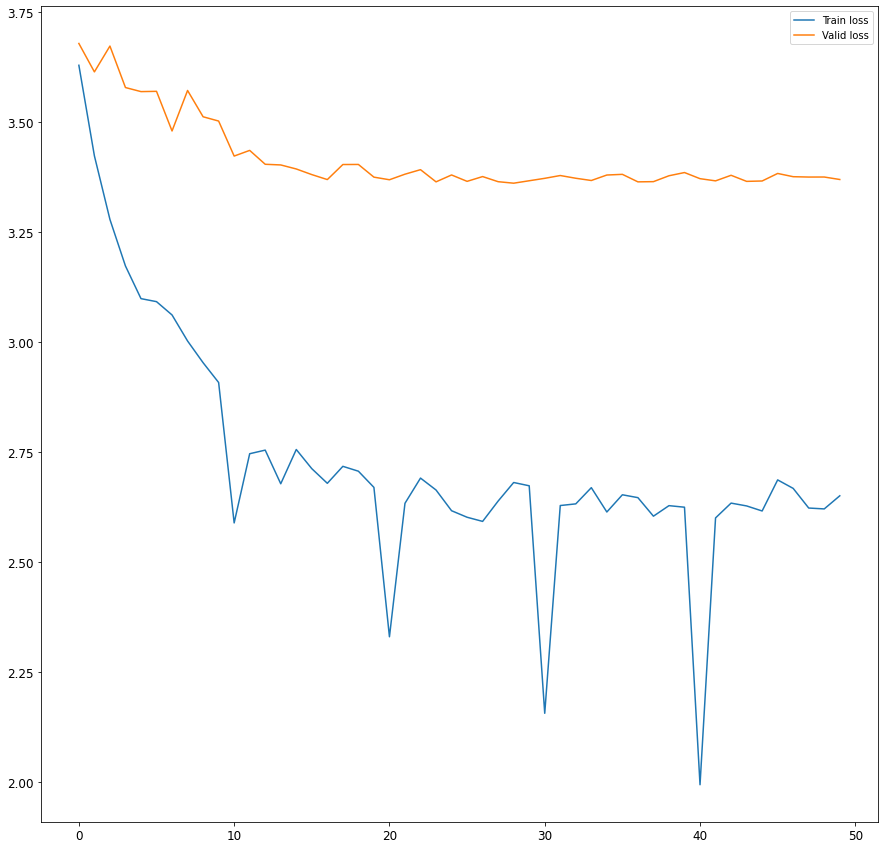

Having the best model

.. train_loss: 2.650.. valid_loss: 3.370 .. valid_accuracy: 11.100%


In [29]:
cloth_utility_exp1.train_model()


In [30]:
# %pip install -U kaleido

In [31]:
cloth_utility_exp1.display_results()

## Load Model

In [32]:
# model.state_dict

In [1]:
import re
import os
if os.path.isdir('./checkpoints/'):
    check_folders = sorted(os.listdir('./checkpoints/'))
    if len(check_folders) > 0:
        nums = list()
        for folder in check_folders:
            match = re.search(r'[0-9]+', folder)
            if match:
                nums.append(int(match.group()))
        if len(nums) > 0:
            last_num = nums[-1] + 1
print(last_num)
# last_num = 1

<re.Match object; span=(1, 3), match='10'>

In [33]:
if TYPE_LOAD_MODEL == 'create_new':
    TYPE_LOAD_MODEL = 'load_best'
load_model, _ = utils.find_last_version_model(
    dir_checkpoint=None, type_load_model=TYPE_LOAD_MODEL)
if load_model:
    model, optimizer, checkpoint_dict = load_checkpoint(load_model, checkpoint_dict, Network)
else:
    print("no loaded models")

Loading the model and the hyperparameters
Model loaded from ./checkpoints/v9/best_checkpoint.pth
Info about checkpoint model:
Epoch: 1 .. train_loss: 4.149, valid_loss: 3.830, valid_accuracy: 6.250


## Testing

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Metrics:</u></b><br>


 - The original data is highly imbalanced so the best metric here is the **F score**
 but reducing the data which is now almost balanced, except some classes have very data. So I left the metric as **accuracy**.

In [34]:
checkpoint_dict['arch']

'custom_cnn'

### <span style="color:#e76f51;">Evaluation</span>

In [35]:
test_loss, test_accuracy = evaluate(
    model, criterion, data_loaders['test'], desc='Test')

print("test_loss: {:.3f}, test_accuracy: {:.3f}%".format(
    test_loss, test_accuracy*100))


test_loss: 3.857, test_accuracy: 0.450%


### <span style="color:#e76f51;">Visualiaztion</span>

In [36]:
from PIL import Image
import numpy as  np
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns numpy
    '''
    # TODO: Process a PIL image for use in a PyTorch model

    # resize the image with  keeping the aspect ratio
    
    w, h = image.size
    aspect_ratio = w/h
    if w < h:
        image = image.resize((256, int(round(256/aspect_ratio))))
    else:
        image = image.resize((int(round(256*aspect_ratio)), 256))
    # crop out the center 224x224 portion of the image
    w, h = image.size
    image = image.crop(((w-IMAGE_WIDTH)/2, (h-IMAGE_HEIGHT)/2, (w+IMAGE_WIDTH)/2, (h+IMAGE_HEIGHT)/2))
    # the model expected floats 0-1. So, You'll need to convert the values of image
    image = np.array(image)/255
    
    # Normalize
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    image[:,:,0] = (image[:,:,0] - mean[0])/std[0]
    image[:,:,1] = (image[:,:,1] - mean[1])/std[1]
    image[:,:,2] = (image[:,:,2] - mean[2])/std[2]
    # reorder dimentions
    image = image.transpose((2, 0, 1))
    
    return image

In [37]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    with torch.no_grad():
        # in evaluation mode
        model.eval()
        # configure device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)
        # loads image
        image = Image.open(image_path)
        image = process_image(image)
        # convert it into tensor
        image = np.array([image],dtype=np.float32)
        image = torch.from_numpy(image)
    
        image = image.to(device)
        # feedforward
        log_ps = model(image)
        ps = torch.exp(log_ps)
        top_probs, top_class = ps.topk(topk, dim = 1)
        classes_names = []
        for each in top_class[0]:
            classes_names.append(model.class_names[each])
    return top_probs.view(-1).tolist(), classes_names

pred = Turtleneck , actual = Blazer


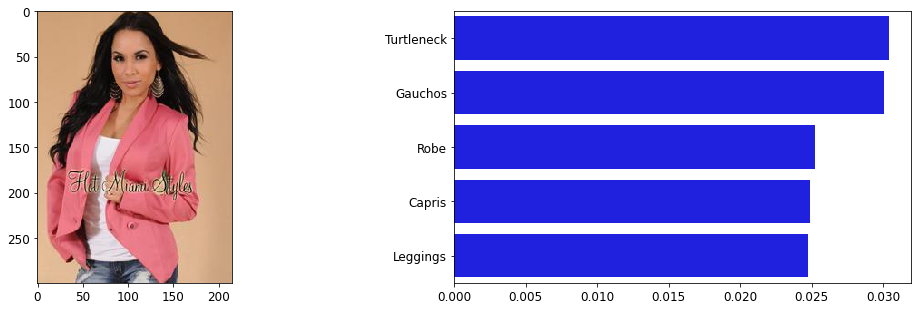

In [38]:
import seaborn as sns
plt.figure(figsize=[18,5])
image_path_list = glob.glob('dataset/images_v2/test/**/*.jpg')
idx = np.random.permutation(len(image_path_list))[0]
image_path = image_path_list[idx]
actual_name = image_path.split('/')[-2]
probs, top_names = predict(image_path, model)

image = Image.open(image_path)
plt.subplot(1,2,1)
plt.imshow(image);
plt.subplot(1,2,2)

sns.barplot(x=probs, y=top_names, color='blue');
print(f"pred = {top_names[0]} , actual = {actual_name}")
plt.show();

In [39]:
# %pip install ptflops

In [40]:
# import torchvision.models as models
# import torch
# from ptflops import get_model_complexity_info

# with torch.cuda.device(0):
#   macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True,
#                                            print_per_layer_stat=True, verbose=True)
#   print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
#   print('{:<30}  {:<8}'.format('Number of parameters: ', params))

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Calculating topk accuracy:</u></b><br>


 - The image has more than a piece of cloth.
 
 - So it is good to calculate topk accuracy and match what we have.

 <!-- https://gist.github.com/weiaicunzai/2a5ae6eac6712c70bde0630f3e76b77b -->

Make sure to keep your approach optimum as much as possible for deployment, with minimal model size and the number of FLOPS.

## Measurements